In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 9]
%load_ext rpy2.ipython
import rpy2.robjects as robjects


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
df = pd.read_pickle('data/prop_data_gap_12_2_1_05_ct_NEST.pkl').drop_duplicates()

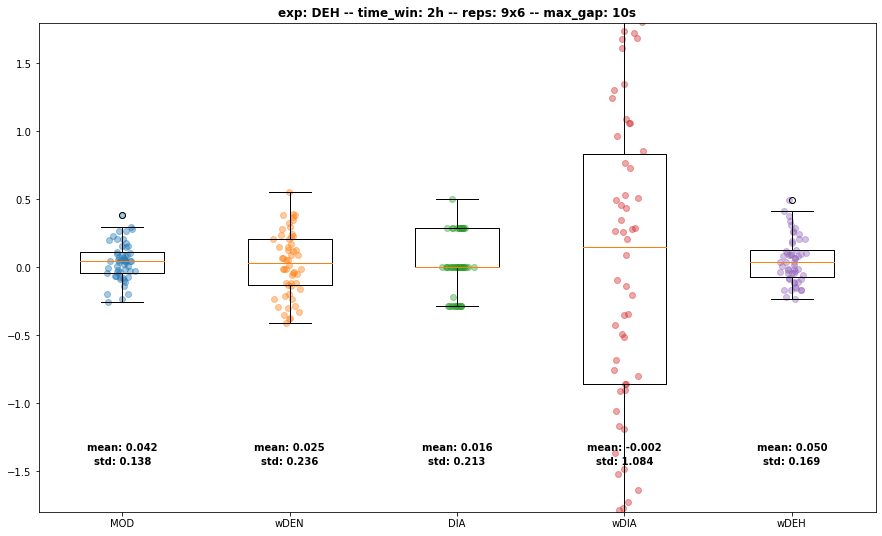

In [153]:
#===== RELATIVE DIFFERENCE =====

# --------- FILTERING ------------
reps_discarded = [20,41]

for exp in ['DEH']:
    time_win = 2 #h
    max_gap = 10 #s

    df_filt = df.loc[(df.time_win==3600 * time_win) & 
                     (df.max_gap==max_gap) & 
                    (df.exp.isin([exp+'a',exp+'b'])) & 
                    (~df.rep.isin(reps_discarded))]
    df_filt.insert(4,'h', [int(str(a)[-8:-6]) for a in df_filt.start])
    df_filt = df_filt.sort_values(['rep','h'])

    # ---- dataframe of relative difference---- 
    #p = df_filt.columns[9:]
    p = ['MOD', 'wDEN', 'DIA', 'wDIA', 'wDEH']
    df_rd = (df_filt[p].diff()/df_filt[p].rolling(2).mean()).iloc[1::2]
    df_rd.insert(0,'rep', df_filt.rep.iloc[1::2])
    df_rd.insert(1,'exp', [a[0:3] for a in df_filt.exp.iloc[1::2]])
    df_rd.insert(3,'start-b', list(df_filt.start.iloc[1::2]))

    vals, names, xs = [],[],[]
    for i, col in enumerate(df_rd[p].columns):
        vals.append(df_rd[col].values)
        names.append(col)
        xs.append(np.random.normal(i + 1, 0.04, df_rd[col].values.shape[0]))  # adds jitter to the data points - can be adjusted
    
    plt.figure()
    box_plot = plt.boxplot(vals, labels=names)
    for x, val in zip(xs, vals):
        plt.scatter(x, val, alpha=0.4)

    means = df_rd[p].mean()
    stds =  df_rd[p].std()

    for xtick in range(len(p)):
        plt.text(xtick+1,-1.35, 'mean: {:.3f}'.format(means[xtick]), 
                  horizontalalignment='center',size='medium',color='k',weight='semibold')
        plt.text(xtick+1,-1.45, 'std: {:.3f}'.format(stds[xtick]), 
                      horizontalalignment='center',size='medium',color='k',weight='semibold')

    plt.ylim([-1.8,1.8])
    fig = plt.title('exp: ' + exp + 
                    ' -- time_win: ' + str(time_win) + 'h'
                    ' -- reps: ' + str(int(len(df_rd)*time_win/12)) + 'x' + str(int(12/time_win)) + 
                    ' -- max_gap: ' + str(max_gap) + 's',
                   fontweight="bold")

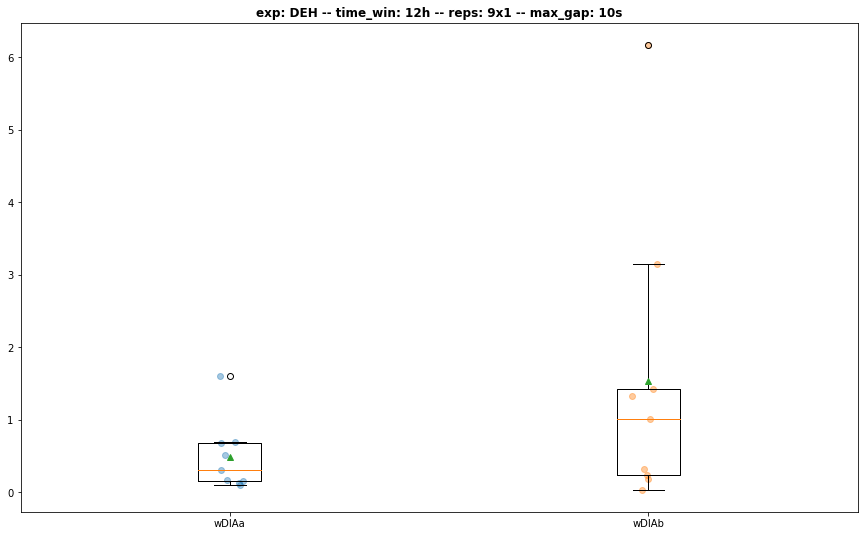

In [154]:
# --------- FILTERING ------------
reps_discarded = [20,41]
exp = 'DEH'
time_win = 12 #h
max_gap = 10 #s
p = 'wDIA'

df_filt = df.loc[(df.time_win==3600 * time_win) & 
                 (df.max_gap==max_gap) & 
                (df.exp.isin([exp+'a',exp+'b'])) & 
                (~df.rep.isin(reps_discarded))]
df_filt.insert(4,'h', [int(str(a)[-8:-6]) for a in df_filt.start])
df_filt = df_filt.sort_values(['rep','h'])



# dataframe for a-b comparison

df_ab = pd.DataFrame()
df_ab.insert(0, p + 'a', list(df_filt[p].iloc[::2]))
df_ab.insert(1, p + 'b', list(df_filt[p].iloc[1::2]))
df_ab

    
# Plotting
vals, names, xs = [],[],[]
for i, col in enumerate(df_ab.columns):
    vals.append(df_ab[col].values)
    names.append(col)
    xs.append(np.random.normal(i + 1, 0.02, df_ab[col].values.shape[0]))  # adds jitter to the data points - can be adjusted


    
box_plot = plt.boxplot(vals, labels=names, showmeans=True)
for x, val in zip(xs, vals):
    plt.scatter(x, val, alpha=0.4)

means = df_ab.mean()
stds =  df_ab.std()

        
#plt.ylim([0,.3])
fig = plt.title('exp: ' + exp + 
                ' -- time_win: ' + str(time_win) + 'h'
                ' -- reps: ' + str(int(len(df_ab)*time_win/12)) + 'x' + str(int(12/time_win)) + 
                ' -- max_gap: ' + str(max_gap) + 's',
               fontweight="bold")

plt.show()


In [155]:
# Stats export to R

import statsmodels.api as sm

# --------- FILTERING ------------
reps_discarded = [20,41]
exp = 'DEH'
time_win = 2 #h
max_gap = 10 #s
p_list = ['MOD','wDIA','wDEN','wDEH']

df_filt = df.loc[(df.time_win==3600 * time_win) & 
                 (df.max_gap==max_gap) & 
                (df.exp.isin([exp+'a',exp+'b'])) & 
                (~df.rep.isin(reps_discarded))]
df_filt.insert(4,'h', [int(str(a)[-8:-6]) for a in df_filt.start])
df_filt = df_filt.sort_values(['rep','h'])



# dataframe for a-b comparison

df_ab = pd.DataFrame()
df_ab.insert(0, 'rep', list(df_filt['rep'].iloc[::2]))
df_ab.insert(1, 'date_exp', [str(a)[0:10] for a in df_filt['start'].iloc[::2]])
df_ab.insert(2,'h', [int(str(a)[-8:-6]) for a in df_filt['start'].iloc[::2]])
for p in p_list:
    df_ab.insert(3, p + 'a', list(df_filt[p].iloc[::2]))
    df_ab.insert(4, p + 'b', list(df_filt[p].iloc[1::2]))

    

df_ab.to_csv('NTM_df_stats.csv')



In [160]:
# Prepare data for Stats

# --------- FILTERING ------------
reps_discarded = [20,41]
exp = 'DEH'
time_win = 12 #h
max_gap = 10 #s
p_list = ['MOD','wDIA','wDEN','wDEH']

df_filt = df.loc[(df.time_win==3600 * time_win) & 
                 (df.max_gap==max_gap) & 
                (df.exp.isin([exp+'a',exp+'b'])) & 
                (~df.rep.isin(reps_discarded))]
df_filt.insert(4,'h', [int(str(a)[-8:-6]) for a in df_filt.start])
#df_filt = df_filt.sort_values(['rep','h'])

rep_to_colony = {i: i for i in range(54)} # TO DO generate dict REP to COLONY --------------------------
rep_to_colony[55]=14

df_filt.insert(5, 'colony', [rep_to_colony[j] for j in df_filt.rep])

df_filt.to_csv('NTM_df_stats.csv')


In [157]:
%%R -o pv_adj -o lmer_p_list
# -----------------------------
# Linear Mixed Effects Model (R)
# -----------------------------
rm(list=ls())
library(lme4)
library(car)

dat <- read.csv("NTM_df_stats.csv",header=T,stringsAsFactors = F)
lmer_p_list <- c('MOD','wDIA','wDEH','DIA')   # list of properties for the LMER test
pv_list <- integer(0)

for (prop in lmer_p_list){
  model <- lmer(formula(paste(prop,' ~ exp + (1|colony)+(1|rep)+(1|h)')), data = dat)
  pv_list <- c(pv_list, print(as.numeric(Anova(model)["exp","Pr(>Chisq)"])))
}

pv_adj <- p.adjust(pv_list, method="BH")
names(pv_adj) <- lmer_p_list

print(pv_adj)


R[write to console]: Error: grouping factors must have > 1 sampled level




Error: grouping factors must have > 1 sampled level


RInterpreterError: Failed to parse and evaluate line '# -----------------------------\n# Linear Mixed Effects Model (R)\n# -----------------------------\nrm(list=ls())\nlibrary(lme4)\nlibrary(car)\n\ndat <- read.csv("NTM_df_stats.csv",header=T,stringsAsFactors = F)\nlmer_p_list <- c(\'MOD\',\'wDIA\',\'wDEH\',\'DIA\')   # list of properties for the LMER test\npv_list <- integer(0)\n\nfor (prop in lmer_p_list){\n  model <- lmer(formula(paste(prop,\' ~ exp + (1|colony)+(1|rep)+(1|h)\')), data = dat)\n  pv_list <- c(pv_list, print(as.numeric(Anova(model)["exp","Pr(>Chisq)"])))\n}\n\npv_adj <- p.adjust(pv_list, method="BH")\nnames(pv_adj) <- lmer_p_list\n\nprint(pv_adj)\n'.
R error message: 'Error: grouping factors must have > 1 sampled level'

In [149]:
{lmer_p_list[i]: pv_adj[i] for i in range(len(pv_adj))}

{'MOD': 0.13652133855663867,
 'wDIA': 0.5678370414204947,
 'wDEH': 0.0092520232342678,
 'DIA': 0.5678370414204947}